In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import arviz as az
import stan

import nest_asyncio
nest_asyncio.apply()

# Simple Multinomial Processing Tree (MPT) Model

A friend performed the recognition task, resulting in 9 hits, 1 miss, 2 false alarms, and 8 correct rejections.

First, we set the true parameters based on our results.

In [42]:
# Global set
global_rng = np.random.default_rng(100)

# Set true probabilities
true_probs = {
    'hit': 0.45,
    'miss': 0.05,
    'alarm': 0.1,
    'reject': 0.4
}

num_trials = 200
data = global_rng.multinomial(n=num_trials, pvals=list(true_probs.values()))

## One-High-Threshold Model

We set the true probabilities and simulate data based on the model (provided in slides).

In [32]:
mpt_one_model = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> d; // uncertainty
  real<lower=0, upper=1> g; // guess
  real<lower=0, upper=1> l; // true or lure
  
}

transformed parameters {
  // Model equations go here
  simplex[4] theta;
  
  theta[1] = l * (d + (1-d) * g);
  theta[2] = (1-l) * g;
  theta[3] = l * ((1-d) * (1-g));
  theta[4] = (1-l) * (1-g);
}

model {

  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);
  target += beta_lpdf(l | 1, 1);
  
  target += dirichlet_lpdf(theta | rep_vector(1,K)); // Prior
  target += multinomial_lpmf(freqs | theta); // Likelihood
}

generated quantities{
  array[K] int y = multinomial_rng(theta, N);
}
"""

In [43]:
### Compile, fit, and diagnose model

# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}

# Compile model
posterior = stan.build(mpt_one_model, data=stan_dict, random_seed=42)

Building: found in cache, done.


In [44]:
# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

#Check summary
az.summary(fit)

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.788,0.045,0.704,0.867,0.000,0.000,8801.0,8085.0,1.0
g,0.187,0.042,0.115,0.270,0.000,0.000,9282.0,7869.0,1.0
l,0.575,0.035,0.512,0.644,0.000,0.000,9843.0,7531.0,1.0
theta[0],0.476,0.036,0.411,0.545,0.000,0.000,9988.0,7069.0,1.0
theta[1],0.080,0.019,0.046,0.117,0.000,0.000,9668.0,7497.0,1.0
theta[2],0.099,0.021,0.061,0.138,0.000,0.000,9882.0,7593.0,1.0
theta[3],0.346,0.034,0.283,0.411,0.000,0.000,9050.0,7386.0,1.0
y[0],95.128,9.988,76.000,113.000,0.100,0.071,10008.0,9276.0,1.0
y[1],15.902,5.421,5.000,25.000,0.055,0.039,9909.0,9527.0,1.0
y[2],19.711,5.891,10.000,31.000,0.059,0.042,9887.0,9209.0,1.0


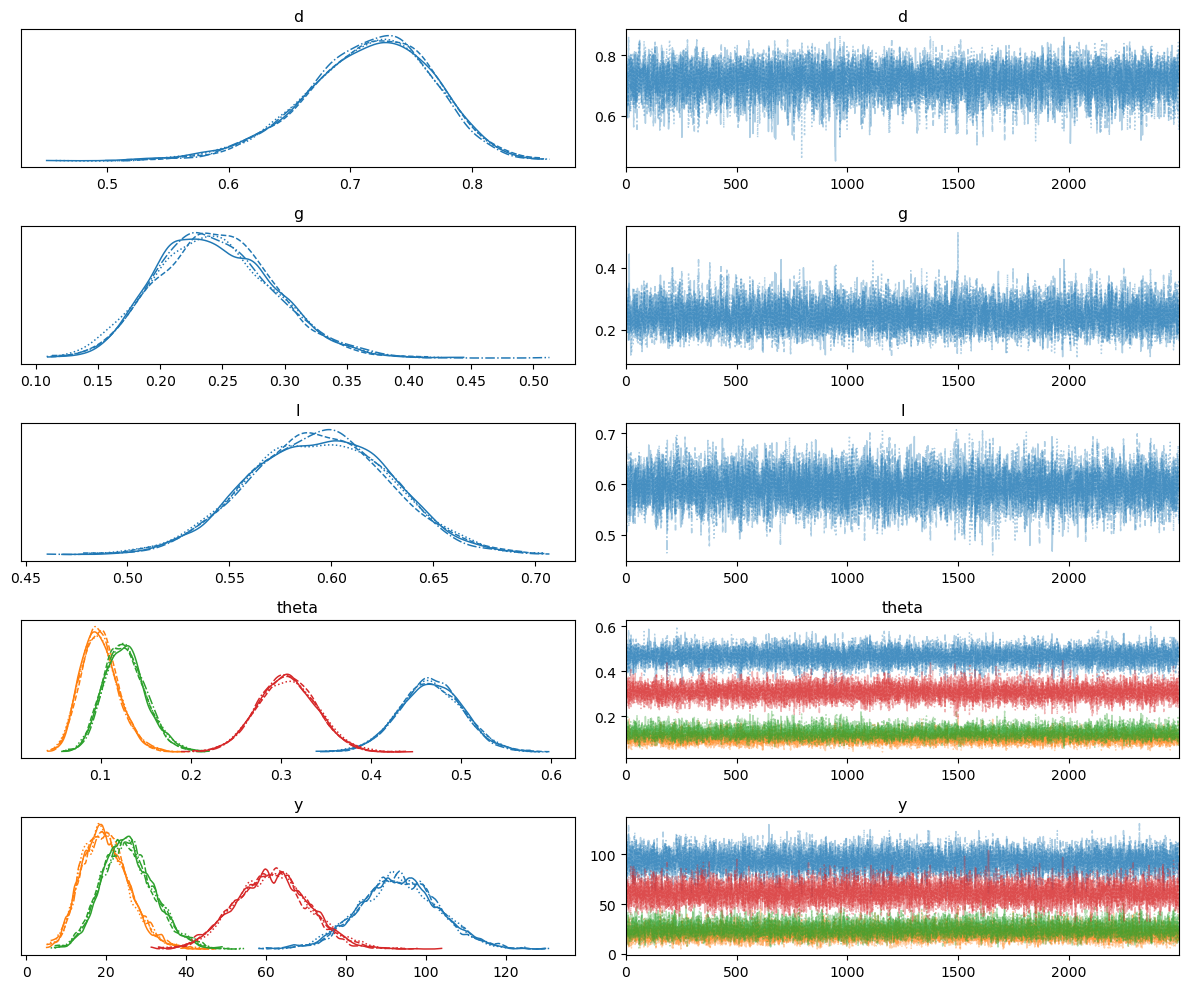

In [36]:
### Parameter recovery and predictions
axarr = az.plot_trace(fit)
plt.tight_layout()

As expected, the results clearly converge in the rough vicinity of the real data values (hit/miss/false alarm/correct rejection). The standard deviations are fairly low.

The model also converges on values around 0.8 for d and 0.2 for g. These are generally expected based on Erdfelder et al. (2009). 

## Two-High-Threshold Model

We now follow the same process with the other model provided.

In [37]:
mpt_two_model = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
  real<lower=0, upper=1> l;
}

transformed parameters {
  // Model equations go here
  simplex[4] theta;
  
  theta[1] = l * (d + (1-d) * g);
  theta[2] = (1-l) * ((1-d) * g);
  theta[3] = l * ((1-d) * (1-g));
  theta[4] = (1-l) * (d + (1-d) * (1-g));
}

model {

  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);
  target += beta_lpdf(l | 1, 1);
  
  target += dirichlet_lpdf(theta | rep_vector(1,K)); // Prior
  target += multinomial_lpmf(freqs | theta); // Likelihood
}

generated quantities{
  array[K] int y = multinomial_rng(theta, N);
}
"""

In [45]:
### Compile, fit, and diagnose model
# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}

# Compile model
posterior = stan.build(mpt_two_model, data=stan_dict, random_seed=42)

Building: found in cache, done.


In [46]:
# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

#Check summary
az.summary(fit)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.654,0.054,0.553,0.754,0.001,0.000,10177.0,7367.0,1.0
g,0.514,0.076,0.373,0.657,0.001,0.001,9337.0,7539.0,1.0
l,0.574,0.035,0.510,0.639,0.000,0.000,8969.0,6401.0,1.0
theta[0],0.478,0.035,0.413,0.542,0.000,0.000,9557.0,7865.0,1.0
theta[1],0.076,0.018,0.044,0.112,0.000,0.000,9096.0,7855.0,1.0
theta[2],0.096,0.021,0.059,0.137,0.000,0.000,11136.0,7932.0,1.0
theta[3],0.350,0.033,0.288,0.412,0.000,0.000,8603.0,6670.0,1.0
y[0],95.640,9.961,76.000,113.000,0.105,0.075,8992.0,8836.0,1.0
y[1],15.159,5.227,5.000,24.000,0.053,0.038,9629.0,9344.0,1.0
y[2],19.228,5.916,9.000,30.000,0.058,0.042,10390.0,8883.0,1.0


In [ ]:
### Parameter recovery and predictions
axarr = az.plot_trace(fit)
plt.tight_layout()

As expected, the model converges more tightly on the data values with a more complex model. The standard deviations are similarly low. 

The model converges on values about 0.7 for d, which is similar to the one-threshold model, but gives a much higher value for g (about 0.5). This can be attributed to the different structure of the two-threshold model, which also introduces uncertainty into the new/lure value attributions.